In [2]:
import numpy as np
import time
import pandas as pd

from torch.utils.data import DataLoader, TensorDataset, StackDataset
from torch.nn.functional import mse_loss
from torch.optim import Adam, SGD, AdamW, Adadelta, Adagrad, Adamax, ASGD, RMSprop, Rprop
from torchmetrics.functional.regression import mean_absolute_error
from lightning import LightningModule, Trainer, LightningDataModule
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import LearningRateMonitor, TQDMProgressBar, LearningRateFinder, StochasticWeightAveraging, RichProgressBar, Timer
from torch.optim.lr_scheduler import OneCycleLR, ExponentialLR, CosineAnnealingLR, ReduceLROnPlateau, CyclicLR, LinearLR, StepLR, MultiStepLR
from lightning.pytorch.tuner import Tuner
import torch.onnx

import tsai.models.XResNet1dPlus

import json
import seaborn as sns
import seaborn.objects as so
import matplotlib.pyplot as plt
plt.ioff()
sns.set_theme()

%load_ext tensorboard


# Models 

In [3]:
xresnets = {
    "xresnet1d18plus": tsai.models.XResNet1dPlus.xresnet1d18plus,
    "xresnet1d34plus": tsai.models.XResNet1dPlus.xresnet1d34plus,
    "xresnet1d50plus": tsai.models.XResNet1dPlus.xresnet1d50plus,
    "xresnet1d101plus": tsai.models.XResNet1dPlus.xresnet1d101plus,
    "xresnet1d152plus": tsai.models.XResNet1dPlus.xresnet1d152plus,
    "xresnet1d18_deepplus": tsai.models.XResNet1dPlus.xresnet1d18_deepplus,
    "xresnet1d34_deepplus": tsai.models.XResNet1dPlus.xresnet1d34_deepplus,
    "xresnet1d50_deepplus": tsai.models.XResNet1dPlus.xresnet1d50_deepplus,
    "xresnet1d18_deeperplus": tsai.models.XResNet1dPlus.xresnet1d18_deeperplus,
    "xresnet1d34_deeperplus": tsai.models.XResNet1dPlus.xresnet1d34_deeperplus,
    "xresnet1d50_deeperplus": tsai.models.XResNet1dPlus.xresnet1d50_deeperplus,
}

def load_model(arch,seq_len):
    if arch in xresnets:
        model = xresnets[arch](1,2,seq_len) 
    else:
        raise ValueError("Unsupported archticture")
    return model.to("mps")

# Dataset

In [4]:
class CSPDataModule(LightningDataModule):
    def __init__(self, json_file, batch_size = 32, num_workers=0, transform=None, frequency=3000, max_time = .5, test_copies=1):
        super().__init__()
        self.json_file = json_file
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.transform = transform
        self.frequency = frequency
        self.max_time = max_time
        self.test_copies = test_copies

    def prepare_data(self):
        with open(self.json_file) as f:
          self.data=json.load(f)
          self.indices = {"test":[], "train":[], "exclude":[]}
          for i,d in enumerate(self.data):
            self.indices[d["split"]].append(i)
          max_index = int(self.frequency*self.max_time)
          self.signals = torch.unsqueeze(torch.tensor(np.array([d["signal"] for d in self.data],dtype=np.float32)[:,:max_index]*1000),dim=1)
          self.csps = torch.tensor(np.array([d["csp_label"] for d in self.data],dtype=np.float32)/self.max_time)
          self.labels = np.array([f'{d["id"]}' for d in self.data])
          self.label_indices = torch.tensor(range(len(self.labels)))
          self.split = np.array([d["split"] for d in self.data])
          self.split_name_to_index = {name: idx for idx,name in enumerate(np.unique(self.split))}
          self.split_index_to_name = {idx: name for idx,name in enumerate(np.unique(self.split))}
          self.split_indices = torch.tensor([self.split_name_to_index[name] for name in self.split])
          self.time_range = np.array([0,self.max_time])

    def setup(self, stage="fit"):
        if stage == "fit":
            self.train_data = StackDataset(signal=self.signals[self.indices["train"]], csp=self.csps[self.indices["train"]])
            self.val_data = StackDataset(signal=self.signals[self.indices["train"]], csp=self.csps[self.indices["train"]])
                        
        elif stage == "test":
            self.test_data =  StackDataset(signal=self.signals.repeat_interleave(self.test_copies, dim=0), csp=self.csps.repeat_interleave(self.test_copies, dim=0), idx= self.label_indices.repeat_interleave(self.test_copies, dim=0), split=self.split_indices.repeat_interleave(self.test_copies, dim=0))

        elif stage == "predict":
            self.predict_data = StackDataset(signal=self.signals.repeat_interleave(self.test_copies, dim=0), idx= self.label_indices.repeat_interleave(self.test_copies, dim=0))

    def to_df(self,dataset, aggregate=False):
        data = {key: value.detach().cpu().numpy() for key, value in dataset.items()}
        if "signal" in data:
            data["signal"] = data["signal"][:,0]
            time = np.linspace(0,1,data["signal"].shape[1])
        if "time_transform" in data:
            start_time, time_length = data["time_transform"][:,0], data["time_transform"][:,1]-data["time_transform"][:,0]
            data.pop("time_transform")
            if "csp_pred" in data:
                data["real_csp_pred"] = (data["csp_pred"]*time_length[:,np.newaxis]+start_time[:,np.newaxis])*self.max_time
        data = {key: value.tolist() for key, value in data.items()}
        df = pd.DataFrame(data)
        if "signal" in data:
            df['time'] = df.apply(lambda x: time, axis=1)
        if "idx" in data:
            df['label'] = df.apply(lambda x: self.labels[x["idx"]], axis=1)
        if "split" in data:
            df['split'] = df.apply(lambda x: self.split_index_to_name[x["split"]], axis=1)
        if not aggregate:
            return df
        df1 = None
        if "csp_pred" in data:
            csp_pred = np.array(list(df["real_csp_pred"]))
            df["real_csp_pred"] = np.concatenate([csp_pred,np.array([csp_pred[:,1]-csp_pred[:,0]]).T],axis=1).tolist()
            df1 = df.groupby("label").agg({"real_csp_pred": [lambda x: np.array(list(x)).mean(axis=0),
                                                             lambda x: np.array(list(x)).std(axis=0),
                                                             lambda x: np.median(np.array(list(x)),axis=0),
                                                             lambda x: np.array(list(x)).min(axis=0),
                                                             lambda x: np.array(list(x)).max(axis=0)
                                                             ]})
            df1.rename(columns={"<lambda_0>": "csp_pred_mean", 
                                "<lambda_1>": "csp_pred_std", 
                                "<lambda_2>": "csp_pred_median",
                                "<lambda_3>": "csp_pred_min",
                                "<lambda_4>": "csp_pred_max"}, inplace=True)
            df1.columns=df1.columns.droplevel(0)
            df1.reset_index(inplace=True)
        csps = np.concatenate([self.csps,np.array([self.csps[:,1].numpy()-self.csps[:,0].numpy()]).T],axis=1)*self.max_time
        df2 = pd.DataFrame({"label": self.labels, "csp": csps.tolist(), "split": self.split.tolist()})
        df = pd.merge(df1,df2,how="inner",on="label") if df1 is not None else df2
        df=df.explode(["csp", "csp_pred_mean", "csp_pred_std", "csp_pred_median","csp_pred_min","csp_pred_max"] if df1 is not None else ["csp"])
        df["type"] = ["on","off","duration"]*(len(df)//3)
        if "csp_pred" in data:
            df["csp_pred_err"] = df["csp_pred_mean"]-df["csp"]
            df["csp_pred_err_abs"] = df["csp_pred_err"].abs()
        return df
    
    def to_fig(self,df, split=True):
        fig,ax = plt.subplots(figsize=(8,6))
        if split:
            g=sns.scatterplot(data=df, x="csp", y="csp_pred_err", hue="csp_pred_std", style="split", ax=ax)
        else:
            g=sns.scatterplot(data=df, x="csp", y="csp_pred_err", hue="csp_pred_std", ax=ax)
        height = df["csp_pred_err_abs"].max()*1.1
        g.set(ylim=(-height,height),xlim=(0,.8),title = df.groupby(["split","type"] if split else ["type"])["csp_pred_err_abs"].mean().to_string())
        df.sort_values(by="csp_pred_err_abs", ascending=False, inplace=True)
        for name,group in df.groupby(["split","type"] if split else ["type"]):
            for row in group.head(2).iterrows():
                g.text(row[1]["csp"],row[1]["csp_pred_err"], "  "+row[1]["label"], horizontalalignment='left', verticalalignment='center',
            size="small", color='black')
        return fig
        
    def train_dataloader(self):
        return DataLoader(self.train_data, batch_size=self.batch_size, num_workers=self.num_workers, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_data, batch_size=self.batch_size, num_workers=self.num_workers)
    
    def test_dataloader(self):
        return DataLoader(self.test_data, batch_size=self.batch_size, num_workers=self.num_workers)
    
    def predict_dataloader(self):
        return DataLoader(self.predict_data, batch_size=self.batch_size, num_workers=self.num_workers)
    
    def on_before_batch_transfer(self, batch, dataloader_idx):
        if self.transform:
            batch = self.transform(batch)
        return batch
    
    def teardown(self, stage: str):
        # Used to clean-up when the run is finished
        pass

def collate(data):
    if isinstance(data[0], dict):
        return { key: torch.cat([d[key] for d in data]) for key in data[0].keys() }

In [5]:
def signal_augmentation(to=512, shift_mag=.2, scale_mag=3., drift_mag=.2, noise_mag=1e-3, center_csp=True, max_label=(0.05,0.5)):
    def transform(batch):
        x = batch["signal"]
        y = batch["csp"] if "csp" in batch else [None]*len(x)
        returnDict = {k:v for k,v in batch.items() if k not in ["signal","csp"]}
        length = x.shape[2]
        x_transform, y_transform = torch.zeros((x.shape[0],1,to)), torch.zeros((x.shape[0],2))
        if "idx" in returnDict:
            time_transform = torch.zeros((x.shape[0],2))
        for i,(signal, label) in enumerate(zip(x,y)):
            label = label if label is not None else torch.tensor(max_label)
            end = (length*(1-label[0]-label[1])/2).int() if center_csp else 0
            signal[0] = torch.concat((signal[0,-end:],signal[0,:-end]))
            label += end/length
            start_index = torch.randint(low=0, high=int(.8*length*label[0]), size=(1,)).item()
            end_index = torch.randint(low=int(1.2*length*label[1]), high=length, size=(1,)).item()
            start_time, end_time = start_index/length, end_index/length
            if "idx" in returnDict:
                time_transform[i] = torch.tensor([start_time-end/length, end_time-end/length])
            x_transform[i,0] = torch.nn.functional.interpolate(signal[:,start_index:end_index].unsqueeze(1), size=(to,),mode="linear",align_corners=True)
            scale_factor = 1/scale_mag + torch.rand((1,)).item() *(scale_mag - 1/scale_mag)
            shift_factor = 2*(torch.rand((1,)).item() - .5)*shift_mag
            drift_factor = 2*(torch.rand((1,)).item() - .5)*drift_mag
            x_transform[i,0] *= scale_factor
            x_transform[i,0] += drift_factor * torch.linspace(0,1,to) + shift_factor + noise_mag*torch.randn((to,))
            y_transform[i] = (label-start_time)/(end_time-start_time)
        if "idx" in returnDict:
            returnDict["time_transform"] = time_transform
        returnDict["signal"] = x_transform
        if "csp" in batch:
            returnDict["csp"] = y_transform
        return returnDict
    return transform

In [6]:
def plot(df,markers={}):
    df=df.explode(["signal","time"]).reset_index()
    for name in markers.keys():
        df=pd.concat([df,pd.DataFrame(df[name].tolist(),columns=[name+"_on",name+"_off"])],axis=1)
    g = (
        so.Plot(data=df, x="time", y="signal")
        .add(so.Line())
        .facet(row="index")
        .limit(y=(-1, 1))
    )
    for name,color in markers.items():
        g = g.add(so.Range(color=color), x=name+"_on", ymin=-1, ymax=1).add(so.Range(color=color), x=name+"_off", ymin=-1, ymax=1)
    return g

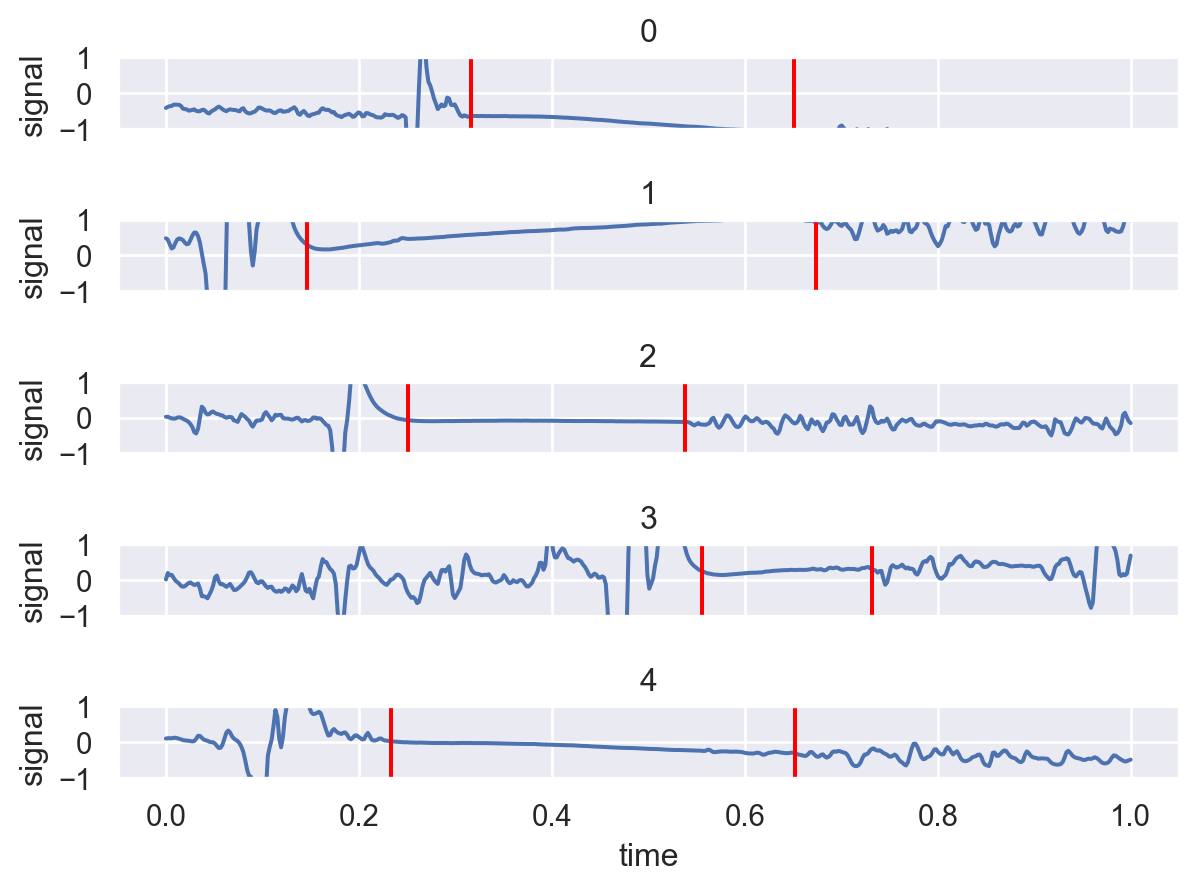

In [7]:
cspdata = CSPDataModule("all_data.json", batch_size=5, num_workers=0, transform=signal_augmentation(to=512, shift_mag=.5, scale_mag=2., drift_mag=1, noise_mag=.001, center_csp=True), frequency=3000, max_time = .5, )
cspdata.prepare_data()
cspdata.setup("test")
batch = next(iter(cspdata.test_dataloader()))
batch = cspdata.on_before_batch_transfer(batch,0)
df = cspdata.to_df(batch)
plot(df,markers={"csp":"red"})

# Learner

In [11]:
class CSPLearner(LightningModule):
    def __init__(self, model, test_every=None, **kwargs):
        super().__init__()
        self.save_hyperparameters(ignore=['model','test_every'])
        self.model = model
        self.test_every = test_every
        self.pred_log = dict()
        self.pred_time = {"epoch": [], "time": []}
        self.start_time = time.time()

    def forward(self, x):
        out = self.model(x)
        return out

    def evaluate(self, batch, stage=None):
        x, y = batch["signal"], batch["csp"]
        assert isinstance(x, torch.Tensor)
        z = self(x)
        loss = mse_loss(y, z)
        mae = mean_absolute_error(y,z)

        if stage is not None:
            self.log(f"{stage}/loss", loss, prog_bar=True, on_step=False, on_epoch=True)
            self.log(f"{stage}/mae", mae, prog_bar=True, on_step=False, on_epoch=True)

        return loss
    
    def predict_step(self, batch, batch_idx):
        x, idx, time_transform = batch["signal"], batch["idx"], batch["time_transform"]
        z = self(x)
        #start_time, time_length = time_transform[:,0], time_transform[:,1]-time_transform[:,0]
        return { "csp_pred": z, "idx": idx, "time_transform": time_transform}#, "real_csp_pred": (z*time_length.unsqueeze(dim=1)+start_time.unsqueeze(dim=1)) }

    def training_step(self, batch, batch_idx):
        return self.evaluate(batch, stage="train")

    def validation_step(self, batch, batch_idx):
        return self.evaluate(batch, stage="val")
    
    def on_validation_epoch_end(self) -> None:
        if self.test_every is not None and self.current_epoch%self.test_every == 1:
            self.trainer.datamodule.setup("test")
            self.on_test_epoch_start()
            for batch in self.trainer.datamodule.test_dataloader():
                batchT = self.trainer.datamodule.on_before_batch_transfer(batch, dataloader_idx=0)
                batchT = self.trainer.datamodule.transfer_batch_to_device(batchT, self.device, dataloader_idx=0)
                batchT = self.trainer.datamodule.on_after_batch_transfer(batchT, dataloader_idx=0)
                self.test_step(batchT, None)
            self.on_test_epoch_end()
            self.trainer.datamodule.setup("fit")
        return super().on_validation_end()
    
    def on_test_epoch_start(self) -> None:
        self.test_pred = []
    
    def test_step(self, batch, batch_idx):
        x, idx, split, time_transform = batch["signal"], batch["idx"], batch["split"], batch["time_transform"]
        z = self(x)
        
        self.test_pred.append( {"csp_pred": z, 
                                "time_transform": time_transform,
                                "idx": idx,
                                "split": split })
    
    def on_test_epoch_end(self) -> None:
        self.pred_time["epoch"].append(self.current_epoch)
        self.pred_time["time"].append(time.time()-self.start_time)
        df = self.trainer.datamodule.to_df(collate(self.test_pred), aggregate=True)
        for row in df.iterrows():
            if row[1]["label"] not in self.pred_log:
                self.pred_log[row[1]["label"]] = dict()
            if row[1]["type"] not in self.pred_log[row[1]["label"]]:
                self.pred_log[row[1]["label"]][row[1]["type"]] = {"mean": [], "std": [], "median": [], "min": [], "max": []}
            self.pred_log[row[1]["label"]][row[1]["type"]]["mean"].append(row[1]["csp_pred_mean"])
            self.pred_log[row[1]["label"]][row[1]["type"]]["std"].append(row[1]["csp_pred_std"])
            self.pred_log[row[1]["label"]][row[1]["type"]]["median"].append(row[1]["csp_pred_median"])
            self.pred_log[row[1]["label"]][row[1]["type"]]["min"].append(row[1]["csp_pred_min"])
            self.pred_log[row[1]["label"]][row[1]["type"]]["max"].append(row[1]["csp_pred_max"])
        
        fig = self.trainer.datamodule.to_fig(df) 
        self.logger.experiment.add_figure("scatter", fig, self.current_epoch)

        for (s,typ),vals in df.groupby(["split","type"])["csp_pred_err"].agg(list).items():
            self.logger.experiment.add_histogram(f"{s}/hist/{typ}", np.array(vals), self.current_epoch)
        
        df.sort_values(by="csp_pred_err_abs", inplace=True, ascending=False)
        dicErr = { f"{s}/predErr/{typ}": num for (s,typ),num in df.groupby(["split","type"])["csp_pred_err_abs"].mean().items() }
        dicStd = { f"{s}/predStd/{typ}": num for (s,typ),num in df.groupby(["split","type"])["csp_pred_std"].mean().items() }
        self.log_dict({**dicErr, **dicStd}, prog_bar=True)
    
    def on_train_start(self):
        self.logger.log_hyperparams(self.hparams, {"val/loss": 1, "train/loss": 1})
        return super().on_train_start()

    def configure_optimizers(self):
        optimizer = self.hparams.Optimizer(
            self.parameters(),
            lr=self.hparams.lr,
            **self.hparams.optimizer_kwargs,
        )
        
        scheduler = self.hparams.Scheduler(optimizer, **self.hparams.scheduler_kwargs) if self.hparams.Scheduler is not None else None
        
        return {"optimizer": optimizer, **({"lr_scheduler": scheduler} if scheduler is not None else {})}

# Training

In [51]:
window_size = 256
batch_size  = 32
lr = 1e-3
lr_end = 1e-4
epochs = 10000
arch = "xresnet1d18plus"
accumulate_grad_batches = 1
test_copies = 5
test_every = 50
shift_mag = .2
scale_mag = 2.
drift_mag = 1e-4
noise_mag = 1e-5
center_csp = False
swa_epoch_start = .7
Optimizer = AdamW
optimizer_kwargs = {"eps": 1e-7, }
#Scheduler = OneCycleLR
#scheduler_kwargs = {"max_lr": lr, "epochs": epochs, "steps_per_epoch": 1, "three_phase": False }
Scheduler = None
scheduler_kwargs = None#{"step_size": 100, "gamma": .5}
json_file = "katrin_data.json"

model = load_model(arch, window_size)
model = model.to("mps")

cspdata = CSPDataModule(
        json_file, 
        batch_size = batch_size, 
        num_workers = 0, 
        transform = signal_augmentation(
            to=window_size, 
            shift_mag=shift_mag, 
            scale_mag=scale_mag, 
            drift_mag=drift_mag, 
            noise_mag=noise_mag, 
            center_csp=center_csp),
        test_copies=test_copies
        )

learner = CSPLearner(
        model, 
        lr=lr, 
        batch_size=batch_size, 
        window_size=window_size, 
        epochs=epochs, 
        accumulate_grad_batches=accumulate_grad_batches, 
        test_every = test_every,
        test_copies = test_copies,
        shift_mag=shift_mag, 
        scale_mag=scale_mag, 
        drift_mag=drift_mag,
        noise_mag=noise_mag,
        center_csp=center_csp,
        swa_epoch_start=swa_epoch_start,
        swa_lrs=lr_end,
        Optimizer=Optimizer,
        optimizer_kwargs=optimizer_kwargs,
        Scheduler=Scheduler,
        scheduler_kwargs=scheduler_kwargs,
        )

trainer = Trainer(
        default_root_dir="lightning_checkpoints/",
        num_sanity_val_steps=0,
        max_epochs=epochs,
        accelerator="auto",
        devices=1,
        logger=TensorBoardLogger("lightning_logs", name=arch, default_hp_metric=False),
        callbacks=[
            LearningRateMonitor(logging_interval="epoch"), 
            LearningRateFinder(),
            RichProgressBar(), 
            StochasticWeightAveraging(swa_lrs=lr_end,swa_epoch_start=swa_epoch_start),
            ],
        log_every_n_steps=1,
        #profiler="simple",
        accumulate_grad_batches=accumulate_grad_batches,
    )

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [52]:
trainer.fit(learner, cspdata)#, ckpt_path=f"lightning_checkpoints/{json_file.split('.')[0]}_{arch}_{window_size}.ckpt")

/Users/dschroeder/miniconda3/envs/ml/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/dschroeder/miniconda3/envs/ml/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 91 steps due to diverging loss.
Learning rate set to 0.000363078054770101
Restoring states from the checkpoint path at lightning_checkpoints/.lr_find_a6c98b51-c542-4377-be3c-f618e7ac4986.ckpt
Restored all states from the checkpoint at lightning_checkpoints/.lr_find_a6c98b51-c542-4377-be3c-f618e7ac4986.ckpt


┏━━━┳━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name  ┃ Type          ┃ Params ┃
┡━━━╇━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ model │ XResNet1dPlus │  3.9 M │
└───┴───────┴───────────────┴────────┘

Trainable params: 3.9 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 3.9 M                                                                                                
Total estimated model params size (MB): 15

Restored all states from the checkpoint at lightning_checkpoints/.lr_find_a6c98b51-c542-4377-be3c-f618e7ac4986.ckpt


Output()

/Users/dschroeder/miniconda3/envs/ml/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


`Trainer.fit` stopped: `max_epochs=10001` reached.


In [53]:
pred_log = []
for sample, data in learner.pred_log.items():
    for typ, vals in data.items():
            for i,(mea,med,std) in enumerate(zip(vals["mean"],vals["median"],vals["std"])):
                pred_log.append({"label": sample, "type": typ, "epoch": learner.pred_time["epoch"][i], "time": learner.pred_time["time"][i], "mean": mea, "median": med, "std": std})
json.dump(pred_log, open(f"pred_log_{json_file.split('.')[0]}_{arch}_{window_size}.json","w"))

In [54]:
trainer.save_checkpoint(f"lightning_checkpoints/{json_file.split('.')[0]}_{arch}_{window_size}.ckpt")

# Inference

In [30]:
infDF = pd.DataFrame()

In [19]:
test_copies = 20
cspAllData = CSPDataModule(
        "andre_data.json", 
        batch_size = batch_size, 
        num_workers = 0, 
        transform = signal_augmentation(
            to=window_size, 
            shift_mag=shift_mag, 
            scale_mag=scale_mag, 
            drift_mag=drift_mag, 
            noise_mag=noise_mag, 
            center_csp=center_csp),
        test_copies=test_copies
)
data = collate(trainer.predict(learner, datamodule=cspAllData))
df = cspAllData.to_df(data,aggregate=True)
df[["csp_pred_err_abs","csp_pred_std","split","type"]].groupby(["split","type"]).agg("mean")

Output()

/Users/dschroeder/miniconda3/envs/ml/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


,label,csp_pred_mean,csp_pred_std,csp_pred_median,csp_pred_min,csp_pred_max,csp,split,type,csp_pred_err,csp_pred_err_abs
0,Andre1,0.05614,0.000731,0.056174,0.054644,0.057322,0.054668,train,on,0.001471,0.001471
0,Andre1,0.133591,0.001155,0.133885,0.131508,0.135289,0.134671,train,off,-0.00108,0.00108
0,Andre1,0.077451,0.001381,0.07737,0.074918,0.080155,0.080003,train,duration,-0.002552,0.002552
1,Andre10,0.056774,0.000647,0.056708,0.055381,0.058441,0.055669,train,on,0.001105,0.001105
1,Andre10,0.114062,0.002004,0.113684,0.109651,0.118039,0.116004,train,off,-0.001942,0.001942
...,...,...,...,...,...,...,...,...,...,...,...
398,Katrin199,0.21604,0.001398,0.215892,0.213782,0.218528,0.220341,test,off,-0.0043,0.0043
398,Katrin199,0.162993,0.001297,0.163087,0.160893,0.165485,0.164339,test,duration,-0.001345,0.001345
399,Katrin200,0.065448,0.002738,0.064954,0.060643,0.07181,0.064335,test,on,0.001112,0.001112
399,Katrin200,0.210435,0.003525,0.21021,0.203215,0.215705,0.21134,test,off,-0.000905,0.000905


In [50]:
df1=df[["csp_pred_err_abs","csp_pred_std","split","type"]].groupby(["split","type"]).agg("mean").T
df1["quantity"]=df1.index
df1
#df1.pivot(columns="quantity")
#df1.pivot(columns="quantity")

split              exclude                          test                      \
type              duration       off        on  duration       off        on   
csp_pred_err_abs  0.019514  0.019577  0.002718  0.006915   0.00577  0.002392   
csp_pred_std      0.008956  0.008437  0.001541  0.003024  0.002771  0.000978   

split                train                              quantity  
type              duration       off        on                    
csp_pred_err_abs  0.001339  0.001041  0.000823  csp_pred_err_abs  
csp_pred_std      0.001837  0.001562  0.000826      csp_pred_std

In [97]:
df

,label,csp_pred_mean,csp_pred_std,csp_pred_median,csp,split,type,csp_pred_err,csp_pred_err_abs
0,Andre1,-0.027843,0.022091,-0.02578,0.109337,train,on,-0.13718,0.13718
0,Andre1,0.058793,0.017679,0.056378,0.269342,train,off,-0.21055,0.21055
0,Andre1,0.086635,0.03299,0.08353,0.160005,train,duration,-0.07337,0.07337
1,Andre10,-0.005424,0.014239,-0.012291,0.111337,train,on,-0.116761,0.116761
1,Andre10,0.035401,0.010828,0.038336,0.232008,train,off,-0.196607,0.196607
...,...,...,...,...,...,...,...,...,...
398,Katrin199,0.039708,0.010981,0.041757,0.440681,train,off,-0.400973,0.400973
398,Katrin199,0.040179,0.016284,0.03928,0.328678,train,duration,-0.288498,0.288498
399,Katrin200,-0.010757,0.013418,-0.009939,0.128671,train,on,-0.139428,0.139428
399,Katrin200,0.037575,0.011614,0.034917,0.422681,train,off,-0.385106,0.385106


In [63]:
pred_dict = dict()
for row in df.iterrows():
    if row[1]["label"] not in pred_dict:
        pred_dict[row[1]["label"]] = dict()
    if row[1]["type"] not in pred_dict[row[1]["label"]]:
        pred_dict[row[1]["label"]][row[1]["type"]] = {"mean": [], "std": [], "median": []}
    pred_dict[row[1]["label"]][row[1]["type"]]["mean"].append(row[1]["csp_pred_mean"])
    pred_dict[row[1]["label"]][row[1]["type"]]["std"].append(row[1]["csp_pred_std"])
    pred_dict[row[1]["label"]][row[1]["type"]]["median"].append(row[1]["csp_pred_median"])

In [65]:
pred_dict["#Andre1"]

{'on': {'mean': [0.11422436609864235],
  'std': [0.003463804911898087],
  'median': [0.11423229426145554]},
 'off': {'mean': [0.26266693472862246],
  'std': [0.004855537394980093],
  'median': [0.26361657679080963]},
 'duration': {'mean': [0.1484425686299801],
  'std': [0.006392242708857678],
  'median': [0.14946216344833374]}}

In [50]:
df1 = None
if "csp_pred" in data:
    csp_pred = np.array(list(df["real_csp_pred"]))
    df["real_csp_pred"] = np.concatenate([csp_pred,np.array([csp_pred[:,1]-csp_pred[:,0]]).T],axis=1).tolist()
    df1 = df.groupby("label").agg({"real_csp_pred": [lambda x: np.array(list(x)).mean(axis=0),lambda x: np.array(list(x)).std(axis=0)]})
    df1.rename(columns={"<lambda_0>": "csp_pred_mean", "<lambda_1>": "csp_pred_std"}, inplace=True)
    df1.columns=df1.columns.droplevel(0)
    df1.reset_index(inplace=True)
df2 = pd.DataFrame({"label": cspAllData.labels, "csp": np.concatenate([cspAllData.csps,np.array([cspAllData.csps[:,1].numpy()-cspAllData.csps[:,0].numpy()]).T],axis=1).tolist(), "split": cspAllData.split.tolist()})
df = pd.merge(df1,df2,how="inner",on="label") if df1 is not None else df2
df=df.explode(["csp", "csp_pred_mean", "csp_pred_std"])
df["type"] = ["on","off","duration"]*(len(df)//3)

In [52]:

df

,label,csp_pred_mean,csp_pred_std,csp,split,type
0,#Andre1,0.115347,0.003889,0.109337,train,on
0,#Andre1,0.262316,0.003393,0.269342,train,off
0,#Andre1,0.146969,0.006067,0.160005,train,duration
1,#Andre10,0.116355,0.00493,0.111337,train,on
1,#Andre10,0.225623,0.006057,0.232008,train,off
...,...,...,...,...,...,...
398,#Katrin199,0.431826,0.005983,0.440681,train,off
398,#Katrin199,0.305322,0.009665,0.328678,train,duration
399,#Katrin200,0.145367,0.009932,0.128671,train,on
399,#Katrin200,0.428927,0.013281,0.422681,train,off


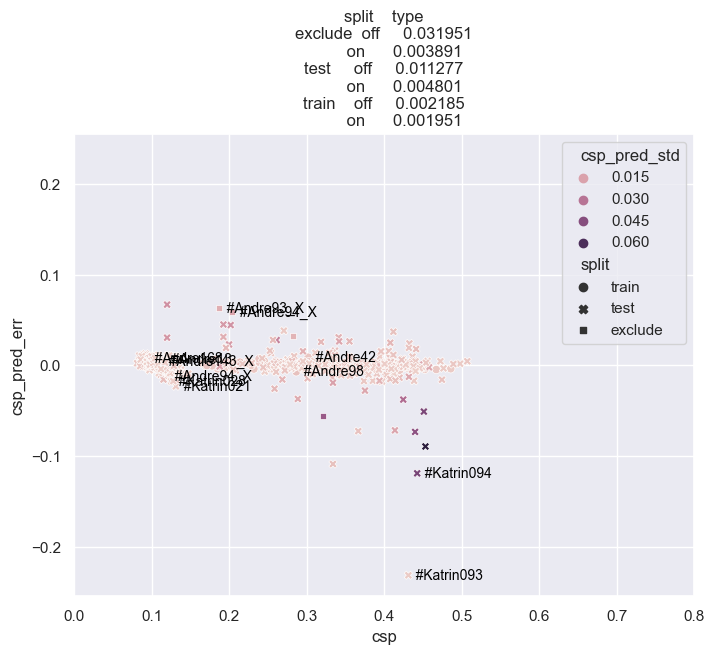

In [146]:
dfK, dfA = df[df["label"].str.contains("Katrin")].copy(), df[df["label"].str.contains("Andre")].copy()
cspAllData.to_fig(df, split=True)

In [148]:
df.head(20)

,label,csp_pred_mean,csp_pred_std,csp,split,type,csp_pred_err,csp_pred_err_abs
292,#Katrin093,0.199876,0.002755,0.431348,test,off,-0.231472,0.231472
293,#Katrin094,0.323547,0.0486,0.442681,test,off,-0.119134,0.119134
294,#Katrin095,0.225153,0.005588,0.334011,test,off,-0.108858,0.108858
290,#Katrin091,0.36383,0.068168,0.453348,test,off,-0.089519,0.089519
299,#Katrin100,0.366577,0.043061,0.440015,test,off,-0.073437,0.073437
275,#Katrin076,0.294057,0.005484,0.366679,test,off,-0.072622,0.072622
44,#Andre139,0.342259,0.014146,0.414014,test,off,-0.071755,0.071755
345,#Katrin146,0.186865,0.020529,0.120004,test,off,0.066861,0.066861
193,#Andre93_X,0.24974,0.011504,0.186673,exclude,off,0.063067,0.063067
194,#Andre94_X,0.262439,0.01448,0.204007,exclude,off,0.058432,0.058432


In [413]:
trainer.test(learner, datamodule=cspdataKatrin)

Output()

/Users/dschroeder/miniconda3/envs/ml/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    exclude/predErr/off    │    0.14336510002613068    │
│    exclude/predErr/on     │    0.08633898198604584    │
│    exclude/predStd/off    │    0.01794084534049034    │
│    exclude/predStd/on     │   0.024303484708070755    │
│     test/predErr/off      │    0.29695236682891846    │
│      test/predErr/on      │    0.10135336220264435    │
│     test/predStd/off      │    0.02302478812634945    │
│      test/predStd/on      │   0.028557254001498222    │
│     train/predErr/off     │    0.2968667447566986     │
│     train/predErr/on      │    0.09907346963882446    │
│     train/predStd/off     │   0.023032449185848236    │
│     train/predStd/on      │   0.028533579781651497    │
└───────────────────────────┴───────────────────────────┘

[{'exclude/predErr/off': 0.14336510002613068,
  'exclude/predErr/on': 0.08633898198604584,
  'test/predErr/off': 0.29695236682891846,
  'test/predErr/on': 0.10135336220264435,
  'train/predErr/off': 0.2968667447566986,
  'train/predErr/on': 0.09907346963882446,
  'exclude/predStd/off': 0.01794084534049034,
  'exclude/predStd/on': 0.024303484708070755,
  'test/predStd/off': 0.02302478812634945,
  'test/predStd/on': 0.028557254001498222,
  'train/predStd/off': 0.023032449185848236,
  'train/predStd/on': 0.028533579781651497}]

# Export

In [16]:
torch.save(model,f"{json_file.split('.')[0]}_{arch}_{window_size}.pt")
model.to("mps")
dummy_input = torch.randn(5, 1, window_size, dtype=torch.float32).to("mps")
dynamic_axes = {'input' : {0 : 'batch_size'}, 'output' : {0 : 'batch_size'}}
torch.onnx.export(model, dummy_input, f"{json_file.split('.')[0]}_{arch}_{window_size}.onnx", verbose=True, input_names=["input"], output_names=["output"], dynamic_axes=dynamic_axes)

Exported graph: graph(%input : Float(*, 1, 256, strides=[256, 256, 1], requires_grad=0, device=mps:0),
      %head.3.weight : Float(2, 512, strides=[512, 1], requires_grad=1, device=mps:0),
      %head.3.bias : Float(2, strides=[1], requires_grad=1, device=mps:0),
      %onnx::Conv_223 : Float(32, 1, 3, strides=[3, 3, 1], requires_grad=0, device=mps:0),
      %onnx::Conv_224 : Float(32, strides=[1], requires_grad=0, device=mps:0),
      %onnx::Conv_226 : Float(32, 32, 3, strides=[96, 3, 1], requires_grad=0, device=mps:0),
      %onnx::Conv_227 : Float(32, strides=[1], requires_grad=0, device=mps:0),
      %onnx::Conv_229 : Float(64, 32, 3, strides=[96, 3, 1], requires_grad=0, device=mps:0),
      %onnx::Conv_230 : Float(64, strides=[1], requires_grad=0, device=mps:0),
      %onnx::Conv_232 : Float(64, 64, 3, strides=[192, 3, 1], requires_grad=0, device=mps:0),
      %onnx::Conv_233 : Float(64, strides=[1], requires_grad=0, device=mps:0),
      %onnx::Conv_235 : Float(64, 64, 3, strides